In [1]:
# Setup: Download Codebase and Verify Environment
import os
import subprocess
import sys
from pathlib import Path

# Repository information
REPO_URL = "https://github.com/yimianxyz/homepage.git"
BRANCH = "rl5"
REPO_DIR = "homepage"

def download_codebase():
    """Download the codebase from GitHub if not already present"""
    if os.path.exists(REPO_DIR):
        print(f"Repository directory '{REPO_DIR}' already exists.")
        try:
            os.chdir(REPO_DIR)
            # Check current branch
            result = subprocess.run(['git', 'branch', '--show-current'],
                                  capture_output=True, text=True, check=True)
            current_branch = result.stdout.strip()
            if current_branch != BRANCH:
                print(f"Switching to branch '{BRANCH}'...")
                subprocess.run(['git', 'checkout', BRANCH], check=True)
            # Pull latest changes
            print("Updating repository...")
            subprocess.run(['git', 'pull', 'origin', BRANCH], check=True)
            print(f"✅ Repository updated successfully!")
        except subprocess.CalledProcessError as e:
            print(f"❌ Error updating repository: {e}")
    else:
        print(f"Cloning repository from {REPO_URL} (branch: {BRANCH})...")
        try:
            subprocess.run(['git', 'clone', '-b', BRANCH, REPO_URL, REPO_DIR], check=True)
            print(f"✅ Repository cloned successfully!")
            os.chdir(REPO_DIR)
        except subprocess.CalledProcessError as e:
            print(f"❌ Error cloning repository: {e}")
            return False

    # Verify key files exist
    key_files = [
        'config/constants.py',
        'simulation/processors/input_processor.py',
        'simulation/state_manager/state_manager.py',
        'policy/human_prior/closest_pursuit_policy.py',
        'export_to_js.py'
    ]

    missing_files = []
    for file_path in key_files:
        if not os.path.exists(file_path):
            missing_files.append(file_path)

    if missing_files:
        print(f"⚠️  Warning: Some key files are missing:")
        for file_path in missing_files:
            print(f"  - {file_path}")
        return False

    print(f"✅ All key files found!")
    print(f"📁 Working directory: {os.getcwd()}")
    return True

# Download and setup codebase
success = download_codebase()

if success:
    print("\n🎉 Setup complete! Ready for RL training.")
else:
    print("❌ Setup failed. Please check the errors above and try again.")
    raise RuntimeError("Failed to setup codebase")


Cloning repository from https://github.com/yimianxyz/homepage.git (branch: neuro-predator)...
✅ Repository cloned successfully!
✅ All key files found!
📁 Working directory: /content/homepage

🎉 Setup complete! Ready for RL training.


In [ ]:
# Import Dependencies and Setup Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from datetime import datetime
import time
from collections import deque, defaultdict
from typing import Dict, List, Any, Tuple, Optional
import copy

# Ensure we're in the correct directory and add to Python path
project_root = Path.cwd()
if project_root.name != 'homepage':
    print(f"⚠️  Warning: Current directory is '{project_root.name}', expected 'homepage'")
    print("Make sure the first cell downloaded the repository correctly.")

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
try:
    from config.constants import CONSTANTS
    from simulation.processors import InputProcessor, ActionProcessor
    from simulation.state_manager import StateManager
    from simulation.random_state_generator import RandomStateGenerator
    from policy.human_prior.closest_pursuit_policy import create_closest_pursuit_policy

    print(f"✅ Successfully imported all simulation modules")
    print(f"📁 Project root: {project_root}")
    print(f"🔧 Key constants: MAX_DISTANCE={CONSTANTS.MAX_DISTANCE}, BOID_MAX_SPEED={CONSTANTS.BOID_MAX_SPEED}")

except ImportError as e:
    print(f"❌ Failed to import modules: {e}")
    print("Make sure the repository was downloaded correctly in the first cell.")
    raise

# RL Training Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {DEVICE}")

# Environment Configuration
ENV_CONFIG = {
    'max_episode_steps': 5000,         # Prevent endless episodes
    'canvas_width_range': (320, 3840), # Same as SL data
    'canvas_height_range': (320, 2160), # Same as SL data
    'boid_count_range': (10, 50),       # Same as SL data
}

# PPO Configuration
PPO_CONFIG = {
    'learning_rate': 5e-5,        # Lower than SL training
    'batch_size': 256,            # Same as SL
    'rollout_length': 2048,       # Steps per update
    'epochs_per_update': 1,       # PPO epochs
    'clip_epsilon': 0.05,          # PPO clip parameter
    'value_loss_coef': 0.5,       # Value loss weight
    'entropy_coef': 0.01,         # Exploration bonus
    'gae_lambda': 0.95,           # GAE parameter
    'gamma': 0.99,                # Discount factor
}

print(f"\n📋 Configuration:")
print(f"  Environment: {ENV_CONFIG}")
print(f"  PPO: {PPO_CONFIG}")
print(f"✅ Configuration loaded successfully!")


✅ Successfully imported all simulation modules
📁 Project root: /content/homepage
🔧 Key constants: MAX_DISTANCE=2000, BOID_MAX_SPEED=3.5
🚀 Device: cuda

📋 Configuration:
  Environment: {'max_episode_steps': 1500, 'reward_window': 50, 'base_catch_reward': 1.0, 'canvas_width_range': (320, 3840), 'canvas_height_range': (320, 2160), 'boid_count_range': (1, 50)}
  PPO: {'learning_rate': 3e-05, 'batch_size': 256, 'rollout_length': 2048, 'epochs_per_update': 4, 'clip_epsilon': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.01, 'gae_lambda': 0.95, 'gamma': 0.99}
✅ Configuration loaded successfully!


In [ ]:
# Load SL Trained Model as Starting Point
# First, we need the transformer model definition from SL training

class GEGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        return x * torch.nn.functional.gelu(gate)

class TransformerLayer(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(d_model)
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(d_model)

        # GEGLU FFN with separate projections for export compatibility
        self.ffn_gate_proj = nn.Linear(d_model, ffn_hidden)
        self.ffn_up_proj = nn.Linear(d_model, ffn_hidden)
        self.ffn_down_proj = nn.Linear(ffn_hidden, d_model)

    def forward(self, x, padding_mask=None):
        # Self-attention with residual
        normed = self.norm1(x)
        attn_out, _ = self.self_attn(normed, normed, normed, key_padding_mask=padding_mask)
        x = x + attn_out

        # FFN with residual
        normed = self.norm2(x)
        gate = torch.nn.functional.gelu(self.ffn_gate_proj(normed))
        up = self.ffn_up_proj(normed)
        ffn_out = self.ffn_down_proj(gate * up)
        x = x + ffn_out

        return x

class TransformerPredictor(nn.Module):
    def __init__(self, d_model=128, n_heads=8, n_layers=4, ffn_hidden=512, max_boids=50, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.ffn_hidden = ffn_hidden
        self.max_boids = max_boids

        # CLS token embedding
        self.cls_embedding = nn.Parameter(torch.randn(d_model))

        # Type embeddings
        self.type_embeddings = nn.ParameterDict({
            'cls': nn.Parameter(torch.randn(d_model)),
            'ctx': nn.Parameter(torch.randn(d_model)),
            'predator': nn.Parameter(torch.randn(d_model)),
            'boid': nn.Parameter(torch.randn(d_model))
        })

        # Input projections
        self.ctx_projection = nn.Linear(2, d_model)  # canvas_width, canvas_height
        self.predator_projection = nn.Linear(4, d_model)  # velX, velY, 0, 0 (padded to 4D)
        self.boid_projection = nn.Linear(4, d_model)  # relX, relY, velX, velY

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model, n_heads, ffn_hidden, dropout)
            for _ in range(n_layers)
        ])

        # Output projection
        self.output_projection = nn.Linear(d_model, 2)  # predator action [x, y]

    def forward(self, structured_inputs, padding_mask=None):
        batch_size = len(structured_inputs) if isinstance(structured_inputs, list) else 1

        # Handle single sample vs batch
        if isinstance(structured_inputs, dict):
            structured_inputs = [structured_inputs]
            batch_size = 1

        # Build token sequences for each sample in batch
        sequences = []
        masks = []

        for sample in structured_inputs:
            tokens = []

            # CLS token
            cls_token = self.cls_embedding + self.type_embeddings['cls']
            tokens.append(cls_token)

            # Context token
            ctx_input = torch.tensor([sample['context']['canvasWidth'], sample['context']['canvasHeight']],
                                   dtype=torch.float32, device=self.cls_embedding.device)
            ctx_token = self.ctx_projection(ctx_input) + self.type_embeddings['ctx']
            tokens.append(ctx_token)

            # Predator token - expand to 4D
            predator_input = torch.tensor([sample['predator']['velX'], sample['predator']['velY'], 0.0, 0.0],
                                        dtype=torch.float32, device=self.cls_embedding.device)
            predator_token = self.predator_projection(predator_input) + self.type_embeddings['predator']
            tokens.append(predator_token)

            # Boid tokens
            sample_mask = [False, False, False]  # CLS, CTX, Predator are not padding

            for boid in sample['boids']:
                boid_input = torch.tensor([boid['relX'], boid['relY'], boid['velX'], boid['velY']],
                                        dtype=torch.float32, device=self.cls_embedding.device)
                boid_token = self.boid_projection(boid_input) + self.type_embeddings['boid']
                tokens.append(boid_token)
                sample_mask.append(False)

            # Pad to max_boids + 3 (CLS + CTX + Predator)
            while len(tokens) < self.max_boids + 3:
                padding_token = torch.zeros(self.d_model, device=self.cls_embedding.device)
                tokens.append(padding_token)
                sample_mask.append(True)  # Mark as padding

            sequences.append(torch.stack(tokens))
            masks.append(sample_mask)

        # Stack sequences
        x = torch.stack(sequences)  # [batch_size, seq_len, d_model]

        # Create padding mask
        if padding_mask is None:
            padding_mask = torch.tensor(masks, dtype=torch.bool, device=x.device)

        # Pass through transformer layers
        for layer in self.transformer_layers:
            x = layer(x, padding_mask)

        # Extract CLS token and project to output
        cls_output = x[:, 0]  # [batch_size, d_model]
        action = self.output_projection(cls_output)  # [batch_size, 2]

        # Apply tanh to ensure [-1, 1] range
        action = torch.tanh(action)

        return action.squeeze(0) if batch_size == 1 else action

def load_sl_checkpoint(checkpoint_path: str):
    """Load the SL trained model from checkpoint"""
    print(f"Loading SL checkpoint from {checkpoint_path}...")

    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return None, None

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    # Extract architecture from checkpoint
    if 'architecture' in checkpoint:
        arch = checkpoint['architecture']
        print(f"✅ Found architecture in checkpoint: {arch}")
    else:
        print("⚠️  No architecture found, using default SL architecture")
        arch = {'d_model': 128, 'n_heads': 8, 'n_layers': 4, 'ffn_hidden': 512, 'max_boids': 50}

    # Create model with correct architecture
    model = TransformerPredictor(
        d_model=arch['d_model'],
        n_heads=arch['n_heads'],
        n_layers=arch['n_layers'],
        ffn_hidden=arch['ffn_hidden'],
        max_boids=arch.get('max_boids', 50),
        dropout=0.1
    ).to(DEVICE)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✅ Loaded SL model successfully:")
    print(f"  Epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"  Best val loss: {checkpoint.get('best_val_loss', 'unknown')}")
    print(f"  Architecture: {arch['d_model']}×{arch['n_heads']}×{arch['n_layers']}×{arch['ffn_hidden']}")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")

    return model, arch

# Try to load SL checkpoint - adjust path as needed
sl_checkpoint_paths = [
    "checkpoints/best_model.pt",
    "checkpoints/model_epoch_20.pt",
    "checkpoints/model_epoch_10.pt",
    "checkpoints/model_epoch_5.pt"
]

sl_model = None
sl_architecture = None

for checkpoint_path in sl_checkpoint_paths:
    if os.path.exists(checkpoint_path):
        sl_model, sl_architecture = load_sl_checkpoint(checkpoint_path)
        if sl_model is not None:
            break

if sl_model is None:
    print("⚠️  No SL checkpoint found. Creating random initialized model for testing...")
    # Create model with default architecture for testing
    default_arch = {'d_model': 128, 'n_heads': 8, 'n_layers': 4, 'ffn_hidden': 512, 'max_boids': 50}
    sl_model = TransformerPredictor(**default_arch).to(DEVICE)
    sl_architecture = default_arch
    print(f"✅ Created model with default architecture: {default_arch}")

print(f"\n🎯 SL Model loaded and ready for RL fine-tuning!")


Loading SL checkpoint from checkpoints/best_model.pt...
✅ Found architecture in checkpoint: {'d_model': 128, 'n_heads': 8, 'n_layers': 4, 'ffn_hidden': 512, 'max_boids': 50}
✅ Loaded SL model successfully:
  Epoch: 4
  Best val loss: 0.022057077198353647
  Architecture: 128×8×4×512
  Total parameters: 1,059,842
  Trainable parameters: 1,059,842

🎯 SL Model loaded and ready for RL fine-tuning!


In [ ]:
# Test SL Model to Ensure It Works Properly
def test_sl_model():
    """Test the loaded SL model with sample inputs"""
    print("🧪 Testing SL model with sample inputs...")

    # Create test input (same format as used in training)
    test_input = {
        'context': {'canvasWidth': 0.8, 'canvasHeight': 0.6},
        'predator': {'velX': 0.1, 'velY': -0.2},
        'boids': [
            {'relX': 0.1, 'relY': 0.3, 'velX': 0.5, 'velY': -0.1},
            {'relX': -0.2, 'relY': 0.1, 'velX': -0.3, 'velY': 0.4},
            {'relX': 0.3, 'relY': -0.1, 'velX': 0.2, 'velY': 0.3}
        ]
    }

    # Test single input
    sl_model.eval()
    with torch.no_grad():
        output = sl_model(test_input)

    print(f"✅ Single input test:")
    print(f"  Input: {len(test_input['boids'])} boids")
    print(f"  Output: [{output[0]:.4f}, {output[1]:.4f}]")
    print(f"  Output range: [{output.min():.4f}, {output.max():.4f}]")

    # Verify output is in correct range
    assert output.shape == (2,), f"Expected output shape (2,), got {output.shape}"
    assert torch.all(output >= -1) and torch.all(output <= 1), f"Output not in [-1, 1] range: {output}"

    # Test batch input
    batch_inputs = [test_input, test_input, test_input]
    with torch.no_grad():
        batch_output = sl_model(batch_inputs)

    print(f"✅ Batch input test:")
    print(f"  Batch size: {len(batch_inputs)}")
    print(f"  Output shape: {batch_output.shape}")
    print(f"  Output sample: [{batch_output[0][0]:.4f}, {batch_output[0][1]:.4f}]")

    assert batch_output.shape == (3, 2), f"Expected batch output shape (3, 2), got {batch_output.shape}"
    assert torch.all(batch_output >= -1) and torch.all(batch_output <= 1), f"Batch output not in [-1, 1] range"

    # Test with varying number of boids
    print(f"✅ Testing with different boid counts:")
    for num_boids in [1, 5, 10, 25, 50]:
        test_boids = []
        for i in range(num_boids):
            test_boids.append({
                'relX': random.uniform(-0.5, 0.5),
                'relY': random.uniform(-0.5, 0.5),
                'velX': random.uniform(-0.5, 0.5),
                'velY': random.uniform(-0.5, 0.5)
            })

        test_input_var = {
            'context': {'canvasWidth': 0.8, 'canvasHeight': 0.6},
            'predator': {'velX': 0.1, 'velY': -0.2},
            'boids': test_boids
        }

        with torch.no_grad():
            output_var = sl_model(test_input_var)

        print(f"    {num_boids} boids: [{output_var[0]:.3f}, {output_var[1]:.3f}]")
        assert output_var.shape == (2,), f"Failed for {num_boids} boids"

    print(f"🎉 All SL model tests passed!")
    return True

# Test empty boids case
def test_edge_cases():
    """Test edge cases for the model"""
    print("🔬 Testing edge cases...")

    # Test with no boids
    empty_input = {
        'context': {'canvasWidth': 0.8, 'canvasHeight': 0.6},
        'predator': {'velX': 0.1, 'velY': -0.2},
        'boids': []
    }

    sl_model.eval()
    with torch.no_grad():
        empty_output = sl_model(empty_input)

    print(f"✅ No boids test: [{empty_output[0]:.4f}, {empty_output[1]:.4f}]")
    assert empty_output.shape == (2,), "Failed no boids test"

    # Test with extreme values
    extreme_input = {
        'context': {'canvasWidth': 1.0, 'canvasHeight': 1.0},
        'predator': {'velX': 1.0, 'velY': -1.0},
        'boids': [
            {'relX': 1.0, 'relY': 1.0, 'velX': 1.0, 'velY': 1.0},
            {'relX': -1.0, 'relY': -1.0, 'velX': -1.0, 'velY': -1.0}
        ]
    }

    with torch.no_grad():
        extreme_output = sl_model(extreme_input)

    print(f"✅ Extreme values test: [{extreme_output[0]:.4f}, {extreme_output[1]:.4f}]")
    assert extreme_output.shape == (2,), "Failed extreme values test"
    assert torch.all(extreme_output >= -1) and torch.all(extreme_output <= 1), "Extreme output out of range"

    print(f"🎉 All edge case tests passed!")
    return True

# Run tests
try:
    test_sl_model()
    test_edge_cases()
    print(f"\n✅ SL Model is working correctly and ready for RL training!")

except Exception as e:
    print(f"❌ SL Model test failed: {e}")
    raise


🧪 Testing SL model with sample inputs...
✅ Single input test:
  Input: 3 boids
  Output: [-0.8693, 0.3489]
  Output range: [-0.8693, 0.3489]
✅ Batch input test:
  Batch size: 3
  Output shape: torch.Size([3, 2])
  Output sample: [-0.8693, 0.3489]
✅ Testing with different boid counts:
    1 boids: [-0.696, 0.681]
    5 boids: [-0.008, -0.936]
    10 boids: [-0.615, -0.712]
    25 boids: [-0.788, -0.615]
    50 boids: [0.925, -0.314]
🎉 All SL model tests passed!
🔬 Testing edge cases...
✅ No boids test: [-0.0555, 0.1534]
✅ Extreme values test: [-0.2905, -0.1975]
🎉 All edge case tests passed!

✅ SL Model is working correctly and ready for RL training!


In [ ]:
# Create RL Environment Wrapper
import numpy as np  # Ensure numpy is available for reward computation

class BoidsRLEnvironment:
    """RL Environment wrapper for boids simulation with retrospective rewards"""

    def __init__(self, config=None):
        self.config = config or ENV_CONFIG

        # Initialize simulation components
        self.state_generator = RandomStateGenerator()
        self.state_manager = StateManager()
        self.input_processor = InputProcessor()
        self.action_processor = ActionProcessor()

        # Episode tracking
        self.step_count = 0
        self.episode_buffer = []  # Store detailed step info for retrospective rewards
        self.current_state = None
        self.initial_boid_count = 0

                # Reward configuration
        self.reward_config = {
            'catch_base_reward': 10.0,        # Base reward for each catch (distributed retrospectively)
            'approach_reward_scale': 0.1,     # Scale for approach rewards  
            'min_active_threshold': 5,        # Min steps of consistent approach before rewards
            'max_retrospective_steps': 200,   # Max steps to look back for retrospective rewards
            'min_approach_speed': 0.02,       # Min speed threshold for approach rewards (lowered for normalized space)
            'temporal_decay_rate': 0.95,      # Decay rate for retrospective rewards (closer steps get more)
        }

        # Episode statistics
        self.episode_stats = {
            'boids_caught': 0,
            'total_reward': 0.0,
            'catch_steps': [],
            'approach_reward_total': 0.0,
            'retrospective_reward_total': 0.0,
        }

        print(f"✅ BoidsRLEnvironment initialized:")
        print(f"  Max episode steps: {self.config['max_episode_steps']}")
        print(f"  Reward config: {self.reward_config}")

    def reset(self):
        """Reset environment for new episode"""
        # Generate random episode configuration
        canvas_width = random.randint(*self.config['canvas_width_range'])
        canvas_height = random.randint(*self.config['canvas_height_range'])
        num_boids = random.randint(*self.config['boid_count_range'])

        # Generate initial state
        self.current_state = self.state_generator.generate_scattered_state(
            num_boids, canvas_width, canvas_height
        )

        # Reset episode tracking
        self.step_count = 0
        self.episode_buffer = []
        self.initial_boid_count = len(self.current_state['boids_states'])

        # Reset episode statistics
        self.episode_stats = {
            'boids_caught': 0,
            'total_reward': 0.0,
            'catch_steps': [],
            'approach_reward_total': 0.0,
            'retrospective_reward_total': 0.0,
        }

        # Get initial observation
        observation = self.input_processor.process_inputs(
            self.current_state['boids_states'],
            self.current_state['predator_state']['position'],
            self.current_state['predator_state']['velocity'],
            self.current_state['canvas_width'],
            self.current_state['canvas_height']
        )

        return observation

    def step(self, action):
        """Execute one environment step"""
        # Store current state before action for reward computation
        pre_state = copy.deepcopy(self.current_state)

        # Convert action to simulation format
        action_forces = self.action_processor.process_action(action)
        predator_action = {
            'force_x': action_forces[0],
            'force_y': action_forces[1]
        }

        # Run simulation step
        from simulation.runtime.simulation_runtime import simulation_step
        step_result = simulation_step(
            self.current_state['boids_states'],
            self.current_state['predator_state'],
            predator_action,
            self.current_state['canvas_width'],
            self.current_state['canvas_height']
        )

        # Update state and process catches
        caught_boids = step_result['caught_boids']
        self.current_state['boids_states'] = step_result['boids_states']
        self.current_state['predator_state'] = step_result['predator_state']

        # Store detailed step info for reward computation
        step_data = {
            'step': self.step_count,
            'pre_state': pre_state,
            'post_state': copy.deepcopy(self.current_state),
            'action': action.copy(),
            'caught_boids': caught_boids.copy(),
            'reward': 0.0,  # Will be computed below
        }

        # Compute immediate rewards (dense feedback)
        immediate_reward = self._compute_immediate_reward(pre_state, action)
        step_data['reward'] = immediate_reward

        # Process catches and assign retrospective rewards
        if caught_boids:
            self.episode_stats['boids_caught'] += len(caught_boids)
            self.episode_stats['catch_steps'].append(self.step_count)
            retrospective_reward = self._assign_retrospective_rewards(caught_boids, pre_state)
            step_data['reward'] += retrospective_reward
            self.episode_stats['retrospective_reward_total'] += retrospective_reward

        self.episode_buffer.append(step_data)

        # Remove caught boids (in reverse order to maintain indices)
        for i in reversed(caught_boids):
            self.current_state['boids_states'].pop(i)

        # Update step count and stats
        self.step_count += 1
        current_reward = step_data['reward']
        self.episode_stats['total_reward'] += current_reward

        # Check termination conditions
        done = self._is_episode_done()

        # Get next observation
        if not done:
            next_observation = self.get_current_observation()
        else:
            next_observation = None

        # Episode info
        info = {
            'boids_remaining': len(self.current_state['boids_states']),
            'boids_caught_this_step': len(caught_boids),
            'step_count': self.step_count,
            'episode_stats': self.episode_stats.copy()
        }

        return next_observation, current_reward, done, info

    def _compute_immediate_reward(self, pre_state, action):
        """Compute immediate dense rewards for current step"""
        total_reward = 0.0

        # Approach reward for getting closer to boids
        if len(pre_state['boids_states']) > 0:
            # Get structured inputs (same as what networks see)
            structured_inputs = self.input_processor.process_inputs(
                pre_state['boids_states'],
                pre_state['predator_state']['position'],
                pre_state['predator_state']['velocity'],
                pre_state['canvas_width'],
                pre_state['canvas_height']
            )
            approach_reward = self._compute_approach_reward(structured_inputs)
            total_reward += approach_reward
            self.episode_stats['approach_reward_total'] += approach_reward

        return total_reward

    def _compute_approach_reward(self, structured_inputs):
        """Compute reward for approaching closest boid using relative velocity"""
        if not structured_inputs['boids']:
            return 0.0

        # Get normalized predator velocity from structured inputs
        predator_vel = np.array([structured_inputs['predator']['velX'],
                                structured_inputs['predator']['velY']])

        # Find closest boid using pre-computed relative positions
        min_distance = float('inf')
        closest_boid_data = None

        for boid in structured_inputs['boids']:
            # relX, relY are already normalized relative positions
            rel_pos = np.array([boid['relX'], boid['relY']])
            distance = np.linalg.norm(rel_pos)  # Distance in normalized space
            if distance < min_distance:
                min_distance = distance
                closest_boid_data = boid

        if closest_boid_data is None or min_distance < 1e-6:
            return 0.0

        # Use the relative position as direction (already points from predator to boid)
        direction_to_boid = np.array([closest_boid_data['relX'], closest_boid_data['relY']])
        direction_to_boid_norm = direction_to_boid / np.linalg.norm(direction_to_boid)

        # Get closest boid velocity (already normalized)
        boid_vel = np.array([closest_boid_data['velX'], closest_boid_data['velY']])

        # Compute relative velocity (predator velocity relative to boid)
        relative_vel = predator_vel - boid_vel

        # Compute relative approach speed using dot product
        relative_approach_speed = np.dot(relative_vel, direction_to_boid_norm)

        # Only reward if effectively approaching (positive dot product means closing distance)
        relative_speed_magnitude = np.linalg.norm(relative_vel)
        if relative_approach_speed > 0 and relative_speed_magnitude > self.reward_config['min_approach_speed']:
            # Reward is proportional to effective approach speed
            effective_approach_speed = relative_approach_speed  # Already positive
            reward = self.reward_config['approach_reward_scale'] * effective_approach_speed
            return reward

        return 0.0

    def _assign_retrospective_rewards(self, caught_boid_indices, current_state):
        """
        Assign retrospective rewards to steps that led to catches using temporal decay.

        More recent approach steps get higher rewards since they likely had more direct
        causal impact on the catch. Uses exponential decay: weight = decay_rate^steps_back

        Example with decay_rate=0.95 and 4 approach steps:
        - Most recent step: weight = 1.000 (decay_rate^0)
        - 1 step back: weight = 0.950 (decay_rate^1)
        - 2 steps back: weight = 0.903 (decay_rate^2)
        - 3 steps back: weight = 0.857 (decay_rate^3)

        Weights are normalized so total reward distributed = catch_base_reward
        """
        if not caught_boid_indices:
            return 0.0

        total_retrospective_reward = 0.0

        for caught_idx in caught_boid_indices:
            # Find the boid that was caught (from pre-catch state)
            if caught_idx >= len(current_state['boids_states']):
                continue  # Boid index out of range

            # Look back through episode buffer to find approach steps
            approach_steps = self._find_approach_steps_for_boid(caught_idx, current_state)

            if approach_steps:
                # Distribute catch reward with temporal decay (more recent steps get higher rewards)
                decay_rate = self.reward_config['temporal_decay_rate']
                base_reward = self.reward_config['catch_base_reward']

                # Calculate decay weights (approach_steps is in reverse chronological order)
                weights = []
                for i, step_idx in enumerate(approach_steps):
                    # i=0 is most recent step, gets highest weight
                    weight = decay_rate ** i
                    weights.append(weight)

                # Normalize weights so total distributed reward equals base_reward
                total_weight = sum(weights)
                if total_weight > 0:
                    normalized_weights = [w / total_weight for w in weights]

                    # Assign rewards based on temporal proximity to catch
                    for i, step_idx in enumerate(approach_steps):
                        if 0 <= step_idx < len(self.episode_buffer):
                            step_reward = base_reward * normalized_weights[i]
                            self.episode_buffer[step_idx]['reward'] += step_reward
                            total_retrospective_reward += step_reward

        return total_retrospective_reward

    def _find_approach_steps_for_boid(self, boid_idx, final_state):
        """Find all steps where predator was approaching the caught boid"""
        approach_steps = []
        max_lookback = min(self.reward_config['max_retrospective_steps'], len(self.episode_buffer))

        # Get final boid position (before it was removed)
        if boid_idx >= len(final_state['boids_states']):
            return approach_steps

        target_boid = final_state['boids_states'][boid_idx]
        target_pos = np.array([target_boid['position']['x'], target_boid['position']['y']])

        # Look back through recent steps
        for i in range(max_lookback):
            step_idx = len(self.episode_buffer) - 1 - i
            if step_idx < 0:
                break

            step_data = self.episode_buffer[step_idx]
            pre_state = step_data['pre_state']

            # Check if this step involved approaching the target boid
            if self._was_approaching_boid(pre_state, boid_idx, target_pos):
                approach_steps.append(step_idx)

        return approach_steps

    def _was_approaching_boid(self, state, boid_idx, target_final_pos):
        """Check if predator was approaching specific boid using relative velocity"""
        if boid_idx >= len(state['boids_states']):
            return False

        predator_pos = np.array([state['predator_state']['position']['x'],
                                state['predator_state']['position']['y']])
        predator_vel = np.array([state['predator_state']['velocity']['x'],
                                state['predator_state']['velocity']['y']])

        boid_pos = np.array([state['boids_states'][boid_idx]['position']['x'],
                            state['boids_states'][boid_idx]['position']['y']])
        boid_vel = np.array([state['boids_states'][boid_idx]['velocity']['x'],
                            state['boids_states'][boid_idx]['velocity']['y']])

        # Compute direction to boid
        direction_to_boid = boid_pos - predator_pos
        distance_to_boid = np.linalg.norm(direction_to_boid)

        if distance_to_boid < 1e-6:
            return False

        # Normalize direction
        direction_to_boid_norm = direction_to_boid / distance_to_boid

        # Compute relative velocity (predator velocity relative to boid)
        relative_vel = predator_vel - boid_vel

                # Check if relative velocity has positive dot product (effectively approaching)
        relative_approach_speed = np.dot(relative_vel, direction_to_boid_norm)
        relative_speed_magnitude = np.linalg.norm(relative_vel)
        
        return (relative_approach_speed > 0 and relative_speed_magnitude > self.reward_config['min_approach_speed'])

    def _is_episode_done(self):
        """Check if episode should terminate"""
        # Timeout
        if self.step_count >= self.config['max_episode_steps']:
            return True

        # All boids caught
        if len(self.current_state['boids_states']) == 0:
            return True

        return False

    def get_current_observation(self):
        """Get current observation in structured format"""
        return self.input_processor.process_inputs(
            self.current_state['boids_states'],
            self.current_state['predator_state']['position'],
            self.current_state['predator_state']['velocity'],
            self.current_state['canvas_width'],
            self.current_state['canvas_height']
        )

    def get_episode_buffer(self):
        """Get the complete episode buffer with retrospective rewards"""
        return self.episode_buffer.copy()

    def get_episode_stats(self):
        """Get episode statistics"""
        stats = self.episode_stats.copy()
        stats['efficiency'] = stats['boids_caught'] / self.initial_boid_count if self.initial_boid_count > 0 else 0
        stats['steps_per_catch'] = self.step_count / stats['boids_caught'] if stats['boids_caught'] > 0 else float('inf')

        # Add reward breakdown
        stats['avg_approach_reward'] = stats['approach_reward_total'] / self.step_count if self.step_count > 0 else 0
        stats['retrospective_reward_per_catch'] = (
            stats['retrospective_reward_total'] / stats['boids_caught']
            if stats['boids_caught'] > 0 else 0
        )

        return stats

# Create and test the RL environment
print("🏗️ Creating and testing RL environment...")

env = BoidsRLEnvironment(ENV_CONFIG)

# Test environment reset
print("\n🧪 Testing environment reset...")
obs = env.reset()
print(f"✅ Reset successful:")
print(f"  Initial boids: {len(obs['boids'])}")
print(f"  Canvas size: {obs['context']['canvasWidth']:.3f} x {obs['context']['canvasHeight']:.3f}")
print(f"  Predator velocity: [{obs['predator']['velX']:.3f}, {obs['predator']['velY']:.3f}]")

# Test environment step with random actions
print("\n🧪 Testing environment steps...")
for i in range(5):
    random_action = [random.uniform(-1, 1), random.uniform(-1, 1)]
    next_obs, reward, done, info = env.step(random_action)

    print(f"  Step {i+1}: action=[{random_action[0]:.3f}, {random_action[1]:.3f}], reward={reward:.3f}, boids={info['boids_remaining']}, done={done}")

    if done:
        print(f"  Episode terminated at step {i+1}")
        break

print(f"\n✅ Environment test completed!")
final_stats = env.get_episode_stats()
print(f"  Final episode stats:")
for key, value in final_stats.items():
    if isinstance(value, float):
        print(f"    {key}: {value:.4f}")
    else:
        print(f"    {key}: {value}")
print(f"🎯 RL Environment is ready for training!")

# Test new reward system in detail
print(f"\n🧪 Testing new reward system...")
env_test = BoidsRLEnvironment(ENV_CONFIG)
obs = env_test.reset()

print(f"  Initial state: {len(obs['boids'])} boids")
print(f"  Reward config: {env_test.reward_config}")

# Test a few steps with detailed reward tracking
for i in range(3):
    random_action = [random.uniform(-1, 1), random.uniform(-1, 1)]
    next_obs, reward, done, info = env_test.step(random_action)

    print(f"  Step {i+1}:")
    print(f"    Action: [{random_action[0]:.3f}, {random_action[1]:.3f}]")
    print(f"    Total reward: {reward:.6f}")
    print(f"    Boids remaining: {info['boids_remaining']}")

    # Get reward breakdown from episode stats
    step_stats = env_test.get_episode_stats()
    print(f"    Cumulative approach reward: {step_stats['approach_reward_total']:.6f}")

    if done:
        break

print(f"✅ New reward system test completed!")

🏗️ Creating and testing RL environment...
✅ BoidsRLEnvironment initialized:
  Max episode steps: 1500
  Reward window: 50
  Base catch reward: 1.0

🧪 Testing environment reset...
✅ Reset successful:
  Initial boids: 17
  Canvas size: 1.620 x 0.806
  Predator velocity: [0.093, -0.084]

🧪 Testing environment steps...
  Step 1: action=[-0.017, 0.638], reward=0.000, boids=17, done=False
  Step 2: action=[0.490, 0.829], reward=0.000, boids=17, done=False
  Step 3: action=[-0.543, 0.368], reward=0.000, boids=17, done=False
  Step 4: action=[-0.855, -0.894], reward=0.000, boids=17, done=False
  Step 5: action=[0.286, -0.206], reward=0.000, boids=17, done=False

✅ Environment test completed!
  Final episode stats: {'boids_caught': 0, 'total_reward': 0.0, 'catch_steps': [], 'efficiency': 0.0, 'steps_per_catch': inf}
🎯 RL Environment is ready for training!


In [ ]:
# Define Critic Network and PPO Components
class TransformerCritic(nn.Module):
    """Transformer-based value function critic"""

    def __init__(self, d_model=64, n_heads=4, n_layers=2, ffn_hidden=256, max_boids=50, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.ffn_hidden = ffn_hidden
        self.max_boids = max_boids

        # CLS token embedding
        self.cls_embedding = nn.Parameter(torch.randn(d_model))

        # Type embeddings
        self.type_embeddings = nn.ParameterDict({
            'cls': nn.Parameter(torch.randn(d_model)),
            'ctx': nn.Parameter(torch.randn(d_model)),
            'predator': nn.Parameter(torch.randn(d_model)),
            'boid': nn.Parameter(torch.randn(d_model))
        })

        # Input projections (same as actor but smaller dimension)
        self.ctx_projection = nn.Linear(2, d_model)
        self.predator_projection = nn.Linear(4, d_model)
        self.boid_projection = nn.Linear(4, d_model)

        # Transformer layers (lighter than actor)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model, n_heads, ffn_hidden, dropout)
            for _ in range(n_layers)
        ])

        # Value head
        self.value_head = nn.Linear(d_model, 1)

    def forward(self, structured_inputs):
        batch_size = len(structured_inputs) if isinstance(structured_inputs, list) else 1

        # Handle single sample vs batch
        if isinstance(structured_inputs, dict):
            structured_inputs = [structured_inputs]
            batch_size = 1

        # Build token sequences (same as actor)
        sequences = []
        masks = []

        for sample in structured_inputs:
            tokens = []

            # CLS token
            cls_token = self.cls_embedding + self.type_embeddings['cls']
            tokens.append(cls_token)

            # Context token
            ctx_input = torch.tensor([sample['context']['canvasWidth'], sample['context']['canvasHeight']],
                                   dtype=torch.float32, device=self.cls_embedding.device)
            ctx_token = self.ctx_projection(ctx_input) + self.type_embeddings['ctx']
            tokens.append(ctx_token)

            # Predator token
            predator_input = torch.tensor([sample['predator']['velX'], sample['predator']['velY'], 0.0, 0.0],
                                        dtype=torch.float32, device=self.cls_embedding.device)
            predator_token = self.predator_projection(predator_input) + self.type_embeddings['predator']
            tokens.append(predator_token)

            # Boid tokens
            sample_mask = [False, False, False]

            for boid in sample['boids']:
                boid_input = torch.tensor([boid['relX'], boid['relY'], boid['velX'], boid['velY']],
                                        dtype=torch.float32, device=self.cls_embedding.device)
                boid_token = self.boid_projection(boid_input) + self.type_embeddings['boid']
                tokens.append(boid_token)
                sample_mask.append(False)

            # Pad to max_boids + 3
            while len(tokens) < self.max_boids + 3:
                padding_token = torch.zeros(self.d_model, device=self.cls_embedding.device)
                tokens.append(padding_token)
                sample_mask.append(True)

            sequences.append(torch.stack(tokens))
            masks.append(sample_mask)

        # Stack sequences
        x = torch.stack(sequences)  # [batch_size, seq_len, d_model]

        # Create padding mask
        padding_mask = torch.tensor(masks, dtype=torch.bool, device=x.device)

        # Pass through transformer layers
        for layer in self.transformer_layers:
            x = layer(x, padding_mask)

        # Extract CLS token and compute value
        cls_output = x[:, 0]  # [batch_size, d_model]
        value = self.value_head(cls_output)  # [batch_size, 1]

        return value.squeeze(-1) if batch_size == 1 else value.squeeze(-1)

class PPOBuffer:
    """Buffer for storing PPO rollout data"""

    def __init__(self, size, gamma=0.99, lam=0.95):
        self.size = size
        self.gamma = gamma
        self.lam = lam

        # Storage
        self.observations = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

        # Computed values
        self.advantages = []
        self.returns = []

        self.ptr = 0
        self.full = False

    def store(self, obs, action, reward, value, log_prob, done):
        """Store transition"""
        if len(self.observations) < self.size:
            self.observations.append(obs)
            self.actions.append(action)
            self.rewards.append(reward)
            self.values.append(value)
            self.log_probs.append(log_prob)
            self.dones.append(done)
        else:
            self.observations[self.ptr] = obs
            self.actions[self.ptr] = action
            self.rewards[self.ptr] = reward
            self.values[self.ptr] = value
            self.log_probs[self.ptr] = log_prob
            self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.size
        if self.ptr == 0:
            self.full = True

    def finish_path(self, last_value=0.0):
        """Compute advantages and returns for the stored path"""
        path_len = len(self.rewards)
        if path_len == 0:
            return

        # Convert to numpy for easier computation
        rewards = np.array(self.rewards[-path_len:])
        values = np.array(self.values[-path_len:] + [last_value])
        dones = np.array(self.dones[-path_len:])

        # Compute GAE advantages
        advantages = np.zeros_like(rewards)
        lastgaelam = 0

        for t in reversed(range(path_len)):
            if t == path_len - 1:
                nextnonterminal = 1.0 - dones[t]
                nextvalues = last_value
            else:
                nextnonterminal = 1.0 - dones[t]
                nextvalues = values[t + 1]

            delta = rewards[t] + self.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + self.gamma * self.lam * nextnonterminal * lastgaelam

        # Compute returns
        returns = advantages + values[:-1]

        # Store computed values
        if len(self.advantages) < len(advantages):
            self.advantages.extend(advantages.tolist())
            self.returns.extend(returns.tolist())
        else:
            start_idx = len(self.advantages) - len(advantages)
            self.advantages[start_idx:] = advantages.tolist()
            self.returns[start_idx:] = returns.tolist()

    def get(self):
        """Get all stored data"""
        assert len(self.advantages) == len(self.observations), "Must call finish_path before get"

        data = {
            'observations': self.observations.copy(),
            'actions': np.array(self.actions),
            'returns': np.array(self.returns),
            'advantages': np.array(self.advantages),
            'log_probs': np.array(self.log_probs),
        }

        # Normalize advantages
        data['advantages'] = (data['advantages'] - data['advantages'].mean()) / (data['advantages'].std() + 1e-8)

        return data

    def clear(self):
        """Clear the buffer"""
        self.observations = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        self.advantages = []
        self.returns = []
        self.ptr = 0
        self.full = False

# Create actor and critic networks
print("🧠 Creating actor and critic networks...")

# Actor: Use the loaded SL model
actor = sl_model
actor.train()  # Set to training mode for RL fine-tuning

# Critic: Create smaller transformer for value estimation
critic_config = {
    'd_model': 64,      # Smaller than actor
    'n_heads': 4,       # Fewer heads
    'n_layers': 2,      # Fewer layers
    'ffn_hidden': 256,  # Smaller FFN
    'max_boids': sl_architecture['max_boids'],
    'dropout': 0.1
}

critic = TransformerCritic(**critic_config).to(DEVICE)

# Count parameters
actor_params = sum(p.numel() for p in actor.parameters())
critic_params = sum(p.numel() for p in critic.parameters())

print(f"✅ Networks created:")
print(f"  Actor (SL model): {actor_params:,} parameters")
print(f"  Critic: {critic_params:,} parameters")
print(f"  Total: {actor_params + critic_params:,} parameters")

# Test networks with sample input
print("\\n🧪 Testing actor and critic...")
test_obs = env.reset()

# Test actor
actor.eval()
with torch.no_grad():
    actor_output = actor(test_obs)
print(f"✅ Actor test: output shape {actor_output.shape}, range [{actor_output.min():.3f}, {actor_output.max():.3f}]")

# Test critic
critic.eval()
with torch.no_grad():
    critic_output = critic(test_obs)
print(f"✅ Critic test: output shape {critic_output.shape}, value {critic_output.item():.3f}")

print(f"\\n🎯 Actor and Critic networks ready for PPO training!")


🧠 Creating actor and critic networks...
✅ Networks created:
  Actor (SL model): 1,059,842 parameters
  Critic: 134,465 parameters
  Total: 1,194,307 parameters
\n🧪 Testing actor and critic...
✅ Actor test: output shape torch.Size([2]), range [-0.669, 0.725]
✅ Critic test: output shape torch.Size([1]), value -0.668
\n🎯 Actor and Critic networks ready for PPO training!


In [ ]:
# PPO Training Algorithm
class PPOTrainer:
    """PPO trainer for the boids RL environment"""

    def __init__(self, actor, critic, env, config):
        self.actor = actor
        self.critic = critic
        self.env = env
        self.config = config

        # Optimizers
        self.actor_optimizer = optim.AdamW(actor.parameters(), lr=config['learning_rate'])
        self.critic_optimizer = optim.AdamW(critic.parameters(), lr=config['learning_rate'])

        # PPO buffer
        self.buffer = PPOBuffer(
            size=config['rollout_length'],
            gamma=config['gamma'],
            lam=config['gae_lambda']
        )

        # Training metrics
        self.training_metrics = defaultdict(list)

        print(f"✅ PPO Trainer initialized:")
        print(f"  Learning rate: {config['learning_rate']}")
        print(f"  Rollout length: {config['rollout_length']}")
        print(f"  Clip epsilon: {config['clip_epsilon']}")

    def get_action_and_value(self, obs, deterministic=False):
        """Get action and value from networks"""
        self.actor.eval()
        self.critic.eval()

        with torch.no_grad():
            # Get action from actor (deterministic output)
            action_mean = self.actor(obs)

            # Add exploration noise for stochastic policy
            if not deterministic:
                # Use fixed std for simplicity (could be learned)
                action_std = 0.1
                action = action_mean + torch.randn_like(action_mean) * action_std
                # Clip to [-1, 1] range
                action = torch.clamp(action, -1, 1)

                # Compute log probability (assuming Gaussian)
                log_prob = -0.5 * (((action - action_mean) / action_std) ** 2 + 2 * np.log(action_std) + np.log(2 * np.pi))
                log_prob = log_prob.sum()  # Sum across action dimensions
            else:
                action = torch.clamp(action_mean, -1, 1)
                log_prob = torch.tensor(0.0)

            # Get value from critic
            value = self.critic(obs)

        # Convert everything to CPU and extract values
        return action.cpu().numpy(), value.cpu().item(), log_prob.cpu().item()

    def collect_rollout(self):
        """Collect a rollout of experiences"""
        obs = self.env.reset()

        for step in range(self.config['rollout_length']):
            # Get action and value
            action, value, log_prob = self.get_action_and_value(obs)

            # Take step in environment
            next_obs, reward, done, info = self.env.step(action)

            # Store in buffer (all values are now CPU scalars/arrays)
            self.buffer.store(obs, action, reward, value, log_prob, done)

            obs = next_obs

            if done:
                obs = self.env.reset()

        # Always finish the path at the end of rollout
        if len(self.buffer.observations) > 0:
            # Get final value for advantage computation
            _, final_value, _ = self.get_action_and_value(obs)

            # If last episode didn't complete, use the final value; otherwise use 0
            last_done = self.buffer.dones[-1] if self.buffer.dones else False
            last_value = 0.0 if last_done else final_value

            self.buffer.finish_path(last_value=last_value)

    def update_networks(self):
        """Update actor and critic networks using PPO"""
        # Get rollout data
        data = self.buffer.get()

        # Convert to tensors
        observations = data['observations']
        actions = torch.tensor(data['actions'], dtype=torch.float32, device=DEVICE)
        returns = torch.tensor(data['returns'], dtype=torch.float32, device=DEVICE)
        advantages = torch.tensor(data['advantages'], dtype=torch.float32, device=DEVICE)
        old_log_probs = torch.tensor(data['log_probs'], dtype=torch.float32, device=DEVICE)

        # Training metrics for this update
        policy_losses = []
        value_losses = []
        kl_divergences = []
        clip_fractions = []

        # PPO update epochs
        for epoch in range(self.config['epochs_per_update']):
            # Shuffle data
            batch_size = self.config['batch_size']
            indices = torch.randperm(len(observations))

            # Mini-batch updates
            for start in range(0, len(observations), batch_size):
                end = start + batch_size
                mb_indices = indices[start:end]

                mb_obs = [observations[i] for i in mb_indices]
                mb_actions = actions[mb_indices]
                mb_returns = returns[mb_indices]
                mb_advantages = advantages[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]

                # Forward pass through networks
                self.actor.train()
                self.critic.train()

                # Actor forward pass
                action_means = self.actor(mb_obs)

                # Compute log probabilities (assuming fixed std)
                action_std = 0.1
                log_probs = -0.5 * (((mb_actions - action_means) / action_std) ** 2 +
                                   2 * np.log(action_std) + np.log(2 * np.pi))
                log_probs = log_probs.sum(dim=-1)  # Sum across action dimensions

                # Critic forward pass
                values = self.critic(mb_obs)

                # PPO policy loss
                ratio = torch.exp(log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1 - self.config['clip_epsilon'],
                                  1 + self.config['clip_epsilon']) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                value_loss = F.mse_loss(values, mb_returns)

                # Entropy bonus (simple approximation)
                entropy = 0.5 * (1 + np.log(2 * np.pi * action_std**2))
                entropy_loss = -self.config['entropy_coef'] * entropy

                # Total actor loss
                actor_loss = policy_loss + entropy_loss

                # Update actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
                self.actor_optimizer.step()

                # Update critic
                self.critic_optimizer.zero_grad()
                critic_loss = self.config['value_loss_coef'] * value_loss
                critic_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
                self.critic_optimizer.step()

                # Collect metrics
                with torch.no_grad():
                    kl_div = (mb_old_log_probs - log_probs).mean()
                    clip_frac = ((ratio - 1).abs() > self.config['clip_epsilon']).float().mean()

                    policy_losses.append(policy_loss.item())
                    value_losses.append(value_loss.item())
                    kl_divergences.append(kl_div.item())
                    clip_fractions.append(clip_frac.item())

        # Store training metrics
        self.training_metrics['policy_loss'].append(np.mean(policy_losses))
        self.training_metrics['value_loss'].append(np.mean(value_losses))
        self.training_metrics['kl_divergence'].append(np.mean(kl_divergences))
        self.training_metrics['clip_fraction'].append(np.mean(clip_fractions))

        # Clear buffer
        self.buffer.clear()

    def train_step(self):
        """Single training step: collect rollout + update networks"""
        # Collect rollout
        self.collect_rollout()

        # Update networks
        self.update_networks()

        return self.training_metrics

# Create PPO trainer
print("🎯 Creating PPO trainer...")
trainer = PPOTrainer(actor, critic, env, PPO_CONFIG)

# Test a single training step
print("\n🧪 Testing a single training step...")
try:
    start_time = time.time()
    metrics = trainer.train_step()
    step_time = time.time() - start_time

    print(f"✅ Training step completed in {step_time:.2f}s")
    print(f"  Policy loss: {metrics['policy_loss'][-1]:.4f}")
    print(f"  Value loss: {metrics['value_loss'][-1]:.4f}")
    print(f"  KL divergence: {metrics['kl_divergence'][-1]:.6f}")
    print(f"  Clip fraction: {metrics['clip_fraction'][-1]:.3f}")

except Exception as e:
    print(f"❌ Training step failed: {e}")
    raise

print(f"\n🚀 PPO trainer is ready for full training!")

🎯 Creating PPO trainer...
✅ PPO Trainer initialized:
  Learning rate: 3e-05
  Rollout length: 2048
  Clip epsilon: 0.2

🧪 Testing a single training step...
✅ Training step completed in 184.87s
  Policy loss: 0.1833
  Value loss: 0.0071
  KL divergence: 6.613864
  Clip fraction: 0.832

🚀 PPO trainer is ready for full training!


In [ ]:
# Comprehensive Reward System Test - Detailed Analysis
def test_reward_system_detailed():
    """
    Comprehensive test of the reward system with detailed intermediate calculations
    Output is designed to be copy-pastable to AI agents for analysis
    """
    print("="*80)
    print("COMPREHENSIVE REWARD SYSTEM TEST")
    print("="*80)

    # Create test environment with deterministic setup
    test_env = BoidsRLEnvironment(ENV_CONFIG)

    # Manual setup for predictable test case
    print("\n" + "="*50)
    print("INITIAL SETUP")
    print("="*50)

    # Create a controlled initial state
    test_env.current_state = {
        'canvas_width': 800,
        'canvas_height': 600,
        'predator_state': {
            'position': {'x': 400, 'y': 300},  # Center of canvas
            'velocity': {'x': 0.0, 'y': 0.0}   # Initially stationary
        },
        'boids_states': [
            {
                'position': {'x': 450, 'y': 320},  # Close boid, slightly right and down
                'velocity': {'x': -1.0, 'y': 0.5}   # Moving left and slightly up
            },
            {
                'position': {'x': 300, 'y': 200},  # Further boid, left and up
                'velocity': {'x': 2.0, 'y': 1.0}    # Moving right and down
            }
        ]
    }

    test_env.step_count = 0
    test_env.initial_boid_count = len(test_env.current_state['boids_states'])
    test_env.episode_buffer = []

    print(f"Canvas size: {test_env.current_state['canvas_width']} x {test_env.current_state['canvas_height']}")
    print(f"Initial boid count: {test_env.initial_boid_count}")
    print(f"Predator position: ({test_env.current_state['predator_state']['position']['x']}, {test_env.current_state['predator_state']['position']['y']})")
    print(f"Predator velocity: ({test_env.current_state['predator_state']['velocity']['x']}, {test_env.current_state['predator_state']['velocity']['y']})")

    for i, boid in enumerate(test_env.current_state['boids_states']):
        print(f"Boid {i}: pos=({boid['position']['x']}, {boid['position']['y']}), vel=({boid['velocity']['x']}, {boid['velocity']['y']})")

    # Test several steps with different actions
    test_actions = [
        [0.8, 0.2],   # Move right and slightly up (toward boid 0)
        [0.6, 0.1],   # Continue similar direction
        [-0.5, -0.3], # Change direction toward boid 1
        [0.9, 0.4],   # Strong movement toward a boid
    ]

    for step_num, action in enumerate(test_actions):
        print(f"\n" + "="*60)
        print(f"STEP {step_num + 1} - ACTION: [{action[0]:.3f}, {action[1]:.3f}]")
        print("="*60)

        # Store pre-step state for detailed analysis
        pre_state = copy.deepcopy(test_env.current_state)

        print(f"\n--- PRE-STEP STATE ---")
        print(f"Step count: {test_env.step_count}")
        print(f"Predator pos: ({pre_state['predator_state']['position']['x']:.3f}, {pre_state['predator_state']['position']['y']:.3f})")
        print(f"Predator vel: ({pre_state['predator_state']['velocity']['x']:.3f}, {pre_state['predator_state']['velocity']['y']:.3f})")

        for i, boid in enumerate(pre_state['boids_states']):
            print(f"Boid {i}: pos=({boid['position']['x']:.3f}, {boid['position']['y']:.3f}), vel=({boid['velocity']['x']:.3f}, {boid['velocity']['y']:.3f})")

        # Get structured inputs (what networks see)
        structured_inputs = test_env.input_processor.process_inputs(
            pre_state['boids_states'],
            pre_state['predator_state']['position'],
            pre_state['predator_state']['velocity'],
            pre_state['canvas_width'],
            pre_state['canvas_height']
        )

        print(f"\n--- STRUCTURED INPUTS (NETWORK VIEW) ---")
        print(f"Context: canvasWidth={structured_inputs['context']['canvasWidth']:.6f}, canvasHeight={structured_inputs['context']['canvasHeight']:.6f}")
        print(f"Predator: velX={structured_inputs['predator']['velX']:.6f}, velY={structured_inputs['predator']['velY']:.6f}")

        for i, boid in enumerate(structured_inputs['boids']):
            print(f"Boid {i}: relX={boid['relX']:.6f}, relY={boid['relY']:.6f}, velX={boid['velX']:.6f}, velY={boid['velY']:.6f}")

                # Detailed approach reward calculation using actual environment method
        print(f"\n--- APPROACH REWARD CALCULATION ---")
        if structured_inputs['boids']:
            predator_vel = np.array([structured_inputs['predator']['velX'], structured_inputs['predator']['velY']])
            print(f"Predator velocity vector: [{predator_vel[0]:.6f}, {predator_vel[1]:.6f}]")
            
            # Find closest boid (for display purposes)
            min_distance = float('inf')
            closest_boid_idx = -1
            
            for i, boid in enumerate(structured_inputs['boids']):
                rel_pos = np.array([boid['relX'], boid['relY']])
                distance = np.linalg.norm(rel_pos)
                print(f"Boid {i}: rel_pos=[{rel_pos[0]:.6f}, {rel_pos[1]:.6f}], distance={distance:.6f}")
                if distance < min_distance:
                    min_distance = distance
                    closest_boid_idx = i
            
            if closest_boid_idx >= 0:
                closest_boid = structured_inputs['boids'][closest_boid_idx]
                print(f"Closest boid: {closest_boid_idx} at distance {min_distance:.6f}")
                
                # Detailed relative velocity calculation (for display)
                boid_vel = np.array([closest_boid['velX'], closest_boid['velY']])
                relative_vel = predator_vel - boid_vel
                
                direction_to_boid = np.array([closest_boid['relX'], closest_boid['relY']])
                direction_norm = direction_to_boid / np.linalg.norm(direction_to_boid)
                
                relative_approach_speed = np.dot(relative_vel, direction_norm)
                relative_speed_magnitude = np.linalg.norm(relative_vel)
                
                print(f"Boid velocity: [{boid_vel[0]:.6f}, {boid_vel[1]:.6f}]")
                print(f"Relative velocity (pred - boid): [{relative_vel[0]:.6f}, {relative_vel[1]:.6f}]")
                print(f"Direction to boid (normalized): [{direction_norm[0]:.6f}, {direction_norm[1]:.6f}]")
                print(f"Relative approach speed (dot product): {relative_approach_speed:.6f}")
                print(f"Relative speed magnitude: {relative_speed_magnitude:.6f}")
                print(f"Min approach speed threshold: {test_env.reward_config['min_approach_speed']}")
                
                # Use actual environment method to get the real result
                approach_reward = test_env._compute_approach_reward(structured_inputs)
                
                # Show the logic the environment is using
                approaching = relative_approach_speed > 0 and relative_speed_magnitude > test_env.reward_config['min_approach_speed']
                print(f"Is approaching (manual calc): {approaching}")
                print(f"Actual environment reward: {approach_reward:.6f}")
                
                if approach_reward > 0:
                    expected = test_env.reward_config['approach_reward_scale'] * relative_approach_speed
                    print(f"Expected reward: {test_env.reward_config['approach_reward_scale']} * {relative_approach_speed:.6f} = {expected:.6f}")
                else:
                    print(f"Environment returned 0 reward - checking why...")
            else:
                approach_reward = 0.0
                print("No valid closest boid found")
        else:
            approach_reward = 0.0
            print("No boids present")

        # Execute the step
        next_obs, reward, done, info = test_env.step(action)

        print(f"\n--- STEP EXECUTION RESULTS ---")
        print(f"Total step reward: {reward:.6f}")
        print(f"Episode done: {done}")
        print(f"Boids remaining: {info['boids_remaining']}")
        print(f"Boids caught this step: {info['boids_caught_this_step']}")

        # Post-step state
        post_state = test_env.current_state
        print(f"\n--- POST-STEP STATE ---")
        print(f"Predator pos: ({post_state['predator_state']['position']['x']:.3f}, {post_state['predator_state']['position']['y']:.3f})")
        print(f"Predator vel: ({post_state['predator_state']['velocity']['x']:.3f}, {post_state['predator_state']['velocity']['y']:.3f})")

        for i, boid in enumerate(post_state['boids_states']):
            print(f"Boid {i}: pos=({boid['position']['x']:.3f}, {boid['position']['y']:.3f}), vel=({boid['velocity']['x']:.3f}, {boid['velocity']['y']:.3f})")

        # Episode buffer analysis
        if test_env.episode_buffer:
            latest_buffer_entry = test_env.episode_buffer[-1]
            print(f"\n--- EPISODE BUFFER ENTRY ---")
            print(f"Step: {latest_buffer_entry['step']}")
            print(f"Action: [{latest_buffer_entry['action'][0]:.6f}, {latest_buffer_entry['action'][1]:.6f}]")
            print(f"Reward: {latest_buffer_entry['reward']:.6f}")
            print(f"Caught boids: {latest_buffer_entry['caught_boids']}")

        # Cumulative episode stats
        episode_stats = test_env.get_episode_stats()
        print(f"\n--- CUMULATIVE EPISODE STATS ---")
        print(f"Boids caught: {episode_stats['boids_caught']}")
        print(f"Total reward: {episode_stats['total_reward']:.6f}")
        print(f"Approach reward total: {episode_stats['approach_reward_total']:.6f}")
        print(f"Retrospective reward total: {episode_stats['retrospective_reward_total']:.6f}")
        print(f"Efficiency: {episode_stats['efficiency']:.3f}")
        print(f"Average approach reward: {episode_stats['avg_approach_reward']:.6f}")

        # If any catches happened, show retrospective reward details
        if info['boids_caught_this_step'] > 0:
            print(f"\n--- RETROSPECTIVE REWARD ANALYSIS ---")
            print(f"Boids caught this step: {info['boids_caught_this_step']}")

            # Show how retrospective rewards were distributed
            print("Episode buffer entries with retrospective rewards:")
            for i, buffer_entry in enumerate(test_env.episode_buffer):
                if buffer_entry['reward'] > approach_reward + 1e-6:  # Has retrospective reward
                    print(f"  Buffer[{i}]: step={buffer_entry['step']}, total_reward={buffer_entry['reward']:.6f}")

            print(f"Retrospective reward distribution completed")

        # Stop if episode is done
        if done:
            print(f"\n🏁 EPISODE TERMINATED")
            break

    print(f"\n" + "="*60)
    print("FINAL EPISODE ANALYSIS")
    print("="*60)

    final_stats = test_env.get_episode_stats()
    print(f"Final episode statistics:")
    for key, value in final_stats.items():
        if isinstance(value, (int, float)):
            if isinstance(value, float):
                print(f"  {key}: {value:.6f}")
            else:
                print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value}")

    print(f"\nComplete episode buffer:")
    for i, entry in enumerate(test_env.episode_buffer):
        print(f"  Step {entry['step']}: action=[{entry['action'][0]:.3f}, {entry['action'][1]:.3f}], reward={entry['reward']:.6f}, caught={entry['caught_boids']}")

    print(f"\n" + "="*60)
    print("TEST COMPLETE - COPY ABOVE OUTPUT FOR ANALYSIS")
    print("="*60)

    return test_env

# Comprehensive Test Suite - Multiple Scenarios
def comprehensive_reward_test_suite():
    """
    Systematic testing of reward system across diverse scenarios
    """
    print("="*80)
    print("COMPREHENSIVE REWARD SYSTEM TEST SUITE")
    print("="*80)
    
    test_scenarios = [
        # Scenario 1: Basic approach scenarios
        {
            "name": "BASIC_APPROACH",
            "description": "Predator approaching stationary boid",
            "predator": {"pos": [400, 300], "vel": [0, 0]},
            "boids": [{"pos": [450, 300], "vel": [0, 0]}],
            "actions": [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]
        },
        # Scenario 2: Relative velocity scenarios
        {
            "name": "RELATIVE_VELOCITY", 
            "description": "Boid moving away, predator chasing",
            "predator": {"pos": [400, 300], "vel": [0, 0]},
            "boids": [{"pos": [450, 300], "vel": [2.0, 0]}],  # Boid moving right
            "actions": [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]  # Chase right
        },
        # Scenario 3: Boid approaching predator
        {
            "name": "BOID_APPROACHING",
            "description": "Boid moving toward predator", 
            "predator": {"pos": [400, 300], "vel": [0, 0]},
            "boids": [{"pos": [450, 300], "vel": [-1.0, 0]}],  # Boid moving left toward predator
            "actions": [[1.0, 0.0], [0.5, 0.0], [0.2, 0.0]]   # Predator moving right (meeting in middle)
        },
        # Scenario 4: Perpendicular movement
        {
            "name": "PERPENDICULAR",
            "description": "Predator and boid moving perpendicular",
            "predator": {"pos": [400, 300], "vel": [0, 0]},
            "boids": [{"pos": [400, 350], "vel": [1.0, 0]}],   # Boid moving right
            "actions": [[0.0, 1.0], [0.0, 1.0], [1.0, 0.0]]   # Predator moving up then right
        },
        # Scenario 5: Multiple boids
        {
            "name": "MULTIPLE_BOIDS",
            "description": "Multiple boids at different distances",
            "predator": {"pos": [400, 300], "vel": [0, 0]},
            "boids": [
                {"pos": [420, 300], "vel": [0, 0]},    # Close boid
                {"pos": [350, 320], "vel": [0.5, -0.5]}, # Further boid, moving
                {"pos": [480, 280], "vel": [-1.0, 1.0]}  # Far boid, moving toward
            ],
            "actions": [[1.0, 0.0], [-1.0, 0.5], [1.5, -0.5], [0.8, 0.2]]
        },
        # Scenario 6: Edge cases
        {
            "name": "EDGE_CASES", 
            "description": "Very slow movements and edge positions",
            "predator": {"pos": [100, 100], "vel": [0, 0]},  # Near edge
            "boids": [{"pos": [105, 105], "vel": [0.01, 0.01]}],  # Very close, very slow
            "actions": [[0.05, 0.05], [0.02, 0.02], [0.001, 0.001]]  # Very small actions
        },
        # Scenario 7: High-speed scenario 
        {
            "name": "HIGH_SPEED",
            "description": "Fast predator chasing fast boid",
            "predator": {"pos": [300, 300], "vel": [1.0, 0]},
            "boids": [{"pos": [400, 320], "vel": [3.0, -0.5]}],  # Fast escaping boid
            "actions": [[1.0, -0.2], [1.0, -0.1], [1.0, 0.0]]   # High-speed pursuit
        },
        # Scenario 8: Catch scenario (close positions to trigger catch)
        {
            "name": "CATCH_SCENARIO",
            "description": "Predator very close to boid to test catches",
            "predator": {"pos": [400, 300], "vel": [2.0, 1.0]},
            "boids": [{"pos": [405, 303], "vel": [-0.5, 0]}],  # Very close boid
            "actions": [[0.8, 0.3], [1.0, 0.2], [1.0, 0.0]]   # Should result in catch
        }
    ]
    
    all_results = {}
    
    for scenario in test_scenarios:
        print(f"\n" + "="*60)
        print(f"SCENARIO: {scenario['name']}")
        print(f"DESCRIPTION: {scenario['description']}")
        print("="*60)
        
        # Setup test environment
        test_env = BoidsRLEnvironment(ENV_CONFIG)
        
        # Configure initial state
        test_env.current_state = {
            'canvas_width': 800,
            'canvas_height': 600,
            'predator_state': {
                'position': {'x': float(scenario['predator']['pos'][0]), 'y': float(scenario['predator']['pos'][1])},
                'velocity': {'x': float(scenario['predator']['vel'][0]), 'y': float(scenario['predator']['vel'][1])}
            },
            'boids_states': []
        }
        
        for boid_data in scenario['boids']:
            test_env.current_state['boids_states'].append({
                'position': {'x': float(boid_data['pos'][0]), 'y': float(boid_data['pos'][1])},
                'velocity': {'x': float(boid_data['vel'][0]), 'y': float(boid_data['vel'][1])}
            })
        
        test_env.step_count = 0
        test_env.initial_boid_count = len(test_env.current_state['boids_states'])
        test_env.episode_buffer = []
        
        print(f"Initial setup:")
        print(f"  Predator: pos=({scenario['predator']['pos'][0]}, {scenario['predator']['pos'][1]}), vel=({scenario['predator']['vel'][0]}, {scenario['predator']['vel'][1]})")
        for i, boid in enumerate(scenario['boids']):
            print(f"  Boid {i}: pos=({boid['pos'][0]}, {boid['pos'][1]}), vel=({boid['vel'][0]}, {boid['vel'][1]})")
        
        scenario_results = {
            'rewards': [],
            'approach_rewards': [],
            'catches': [],
            'relative_speeds': [],
            'distances': []
        }
        
        # Run scenario steps
        for step_idx, action in enumerate(scenario['actions']):
            pre_state = copy.deepcopy(test_env.current_state)
            
            # Get structured inputs for analysis
            structured_inputs = test_env.input_processor.process_inputs(
                pre_state['boids_states'],
                pre_state['predator_state']['position'],
                pre_state['predator_state']['velocity'],
                pre_state['canvas_width'],
                pre_state['canvas_height']
            )
            
            print(f"\n--- Step {step_idx + 1}: Action [{action[0]:.3f}, {action[1]:.3f}] ---")
            
            # Detailed analysis for first boid
            if structured_inputs['boids']:
                predator_vel = np.array([structured_inputs['predator']['velX'], structured_inputs['predator']['velY']])
                
                # Analyze closest boid
                closest_boid = min(structured_inputs['boids'], 
                                 key=lambda b: np.linalg.norm([b['relX'], b['relY']]))
                
                boid_vel = np.array([closest_boid['velX'], closest_boid['velY']])
                relative_vel = predator_vel - boid_vel
                direction = np.array([closest_boid['relX'], closest_boid['relY']])
                distance = np.linalg.norm(direction)
                
                if distance > 1e-6:
                    direction_norm = direction / distance
                    relative_approach_speed = np.dot(relative_vel, direction_norm)
                    relative_speed_magnitude = np.linalg.norm(relative_vel)
                    
                    print(f"  Closest boid distance: {distance:.6f}")
                    print(f"  Predator vel: [{predator_vel[0]:.4f}, {predator_vel[1]:.4f}]")
                    print(f"  Boid vel: [{boid_vel[0]:.4f}, {boid_vel[1]:.4f}]")
                    print(f"  Relative vel: [{relative_vel[0]:.4f}, {relative_vel[1]:.4f}]")
                    print(f"  Relative approach speed: {relative_approach_speed:.6f}")
                    print(f"  Relative speed magnitude: {relative_speed_magnitude:.6f}")
                    
                    # Store metrics
                    scenario_results['relative_speeds'].append(relative_approach_speed)
                    scenario_results['distances'].append(distance)
            
            # Execute step
            next_obs, reward, done, info = test_env.step(action)
            
            print(f"  Total reward: {reward:.6f}")
            print(f"  Boids caught: {info['boids_caught_this_step']}")
            print(f"  Episode done: {done}")
            
            # Store results
            scenario_results['rewards'].append(reward)
            scenario_results['catches'].append(info['boids_caught_this_step'])
            
            if done:
                print(f"  Episode terminated!")
                break
        
        # Scenario summary
        episode_stats = test_env.get_episode_stats()
        print(f"\n--- Scenario Summary ---")
        print(f"  Total reward: {episode_stats['total_reward']:.6f}")
        print(f"  Boids caught: {episode_stats['boids_caught']}")
        print(f"  Approach reward total: {episode_stats['approach_reward_total']:.6f}")
        print(f"  Retrospective reward total: {episode_stats['retrospective_reward_total']:.6f}")
        print(f"  Average approach reward: {episode_stats['avg_approach_reward']:.6f}")
        
        all_results[scenario['name']] = {
            'scenario_results': scenario_results,
            'episode_stats': episode_stats,
            'buffer': test_env.episode_buffer.copy()
        }
    
    print(f"\n" + "="*80)
    print("CROSS-SCENARIO ANALYSIS")
    print("="*80)
    
    # Compare scenarios
    for name, results in all_results.items():
        stats = results['episode_stats']
        print(f"\n{name}:")
        print(f"  Total reward: {stats['total_reward']:.4f}")
        print(f"  Approach reward: {stats['approach_reward_total']:.4f}")
        print(f"  Retrospective reward: {stats['retrospective_reward_total']:.4f}") 
        print(f"  Catches: {stats['boids_caught']}")
        print(f"  Efficiency: {stats['efficiency']:.3f}")
    
    # Find potential issues
    print(f"\n" + "="*60)
    print("POTENTIAL ISSUES DETECTED")
    print("="*60)
    
    issues_found = False
    
    for name, results in all_results.items():
        stats = results['episode_stats']
        scenario_data = results['scenario_results']
        
        # Check for zero rewards when there should be some
        if name in ['BASIC_APPROACH', 'RELATIVE_VELOCITY'] and stats['approach_reward_total'] == 0:
            print(f"⚠️  {name}: No approach rewards despite approach behavior")
            issues_found = True
            
        # Check for catches without retrospective rewards
        if stats['boids_caught'] > 0 and stats['retrospective_reward_total'] == 0:
            print(f"⚠️  {name}: Catches occurred but no retrospective rewards assigned")
            issues_found = True
            
        # Check for negative relative approach speeds getting rewards
        if any(r > 0 for r in scenario_data['rewards']) and any(s < 0 for s in scenario_data['relative_speeds'] if s is not None):
            print(f"⚠️  {name}: Positive rewards with negative approach speeds")
            issues_found = True
    
    if not issues_found:
        print("✅ No obvious issues detected in reward system")
    
    print(f"\n" + "="*80)
    print("TEST SUITE COMPLETE - COPY ABOVE FOR DETAILED ANALYSIS") 
    print("="*80)
    
    return all_results

# Parameter Sweep Test (Quick Coverage)
def parameter_sweep_test():
    """Quick parameter sweep to test edge cases and thresholds"""
    print("="*50)
    print("PARAMETER SWEEP TEST")  
    print("="*50)
    
    # Test different approach speeds around the threshold  
    approach_speeds = [0.01, 0.019, 0.02, 0.025, 0.05, 0.1, 0.2]  # Around threshold of 0.02
    distances = [0.001, 0.01, 0.05, 0.1, 0.2]  # Different distances
    
    print("Testing approach reward calculation directly:")
    print("(Approach Speed, Distance) -> Expected Reward")
    
    for speed in approach_speeds:
        for dist in distances:
            # Mock structured inputs for direct testing
            mock_inputs = {
                'predator': {'velX': speed, 'velY': 0.0},
                'boids': [{'relX': dist, 'relY': 0.0, 'velX': 0.0, 'velY': 0.0}]
            }
            
            # Create a test environment just for reward calculation
            test_env = BoidsRLEnvironment(ENV_CONFIG) 
            reward = test_env._compute_approach_reward(mock_inputs)
            expected = 0.1 * speed if speed > 0.02 else 0.0
            
            status = "✅" if abs(reward - expected) < 1e-6 else "❌"
            print(f"  ({speed:.3f}, {dist:.3f}) -> {reward:.6f} (expected {expected:.6f}) {status}")

def run_all_tests():
    """Run all test variants"""
    print("🔬 RUNNING ALL REWARD SYSTEM TESTS")
    print("="*80)
    
    # 1. Parameter sweep (quick)
    print("\n1. PARAMETER SWEEP TEST")
    parameter_sweep_test()
    
    # 2. Comprehensive scenarios
    print(f"\n2. COMPREHENSIVE SCENARIO TEST")
    test_results = comprehensive_reward_test_suite()
    
    # 3. Quick summary
    print(f"\n" + "="*50)  
    print("TESTING COMPLETE - SUMMARY")
    print("="*50)
    print("✅ Parameter sweep: Tests threshold behaviors")
    print("✅ Comprehensive scenarios: Tests realistic game situations") 
    print("✅ Cross-scenario analysis: Compares reward patterns")
    print("✅ Automated issue detection: Flags potential problems")
    print("\nThe system is now thoroughly tested across diverse conditions!")
    
    return test_results

# Quick test with just the problematic scenarios
def quick_fix_test():
    """Test just the scenarios that were failing"""
    print("🔧 TESTING THRESHOLD FIX")
    print("="*50)
    
    test_env = BoidsRLEnvironment(ENV_CONFIG)
    print(f"New threshold: {test_env.reward_config['min_approach_speed']}")
    
    # Test BASIC_APPROACH scenario with fixed threshold
    test_env.current_state = {
        'canvas_width': 800, 'canvas_height': 600,
        'predator_state': {'position': {'x': 400, 'y': 300}, 'velocity': {'x': 0, 'y': 0}},
        'boids_states': [{'position': {'x': 450, 'y': 300}, 'velocity': {'x': 0, 'y': 0}}]
    }
    test_env.step_count = 0
    test_env.initial_boid_count = 1
    test_env.episode_buffer = []
    
    print("\nTesting BASIC_APPROACH with fixed threshold:")
    
    for i in range(3):
        pre_state = copy.deepcopy(test_env.current_state)
        structured_inputs = test_env.input_processor.process_inputs(
            pre_state['boids_states'], pre_state['predator_state']['position'],
            pre_state['predator_state']['velocity'], pre_state['canvas_width'], pre_state['canvas_height']
        )
        
        # Check reward calculation
        approach_reward = test_env._compute_approach_reward(structured_inputs)
        print(f"  Step {i+1}: Approach reward = {approach_reward:.6f}")
        
        # Execute step
        action = [1.0, 0.0]  # Move right toward boid
        next_obs, reward, done, info = test_env.step(action)
        print(f"           Total reward = {reward:.6f}, Caught = {info['boids_caught_this_step']}")
        
        if done:
            break
    
    # Check final stats
    final_stats = test_env.get_episode_stats()
    print(f"\nFinal results:")
    print(f"  Approach rewards: {final_stats['approach_reward_total']:.6f}")
    print(f"  Retrospective rewards: {final_stats['retrospective_reward_total']:.6f}")
    print(f"  Total boids caught: {final_stats['boids_caught']}")
    
    if final_stats['approach_reward_total'] > 0:
        print("✅ APPROACH REWARDS FIXED!")
    else:
        print("❌ Approach rewards still not working")
        
    if final_stats['boids_caught'] > 0 and final_stats['retrospective_reward_total'] > 0:
        print("✅ RETROSPECTIVE REWARDS WORKING!")
    elif final_stats['boids_caught'] > 0:
        print("⚠️  Caught boids but no retrospective rewards")
    
    return final_stats

# Choose your test level:
print("Select test level:")
print("1. Quick threshold fix test")
print("2. Quick parameter sweep only")  
print("3. Full comprehensive suite only")
print("4. All tests (recommended)")

# Comprehensive Retrospective Rewards Test with Closest Pursuit Policy
def test_retrospective_rewards_with_policy():
    """
    Test retrospective reward system using closest pursuit policy for realistic behavior
    """
    print("🎯 RETROSPECTIVE REWARDS TEST WITH CLOSEST PURSUIT POLICY")
    print("="*70)
    
    # Import and create the closest pursuit policy
    from policy.human_prior.closest_pursuit_policy import create_closest_pursuit_policy
    pursuit_policy = create_closest_pursuit_policy()
    
    test_env = BoidsRLEnvironment(ENV_CONFIG)
    
    # Setup for GUARANTEED catch - very close with favorable initial velocities
    test_env.current_state = {
        'canvas_width': 800,
        'canvas_height': 600, 
        'predator_state': {
            'position': {'x': 400.0, 'y': 300.0},
            'velocity': {'x': 0.3, 'y': 0.2}  # Initial velocity toward boid
        },
        'boids_states': [
            {
                'position': {'x': 430.0, 'y': 320.0},  # Very close (only ~36 units away)
                'velocity': {'x': -0.4, 'y': -0.3}     # Boid moving toward predator (convergent)
            }
        ]
    }
    
    test_env.step_count = 0
    test_env.initial_boid_count = 1
    test_env.episode_buffer = []
    
    print(f"Reward config:")
    print(f"  catch_base_reward: {test_env.reward_config['catch_base_reward']}")
    print(f"  temporal_decay_rate: {test_env.reward_config['temporal_decay_rate']}")
    print(f"  min_approach_speed: {test_env.reward_config['min_approach_speed']}")
    
    initial_distance = ((430-400)**2 + (320-300)**2)**0.5
    print(f"\nInitial setup for GUARANTEED CATCH:")
    print(f"  Predator: pos=(400.0, 300.0), vel=(0.3, 0.2) -> moving toward boid")
    print(f"  Boid: pos=(430.0, 320.0), vel=(-0.4, -0.3) -> moving toward predator")
    print(f"  Initial distance: {initial_distance:.1f} units (very close!)")
    print(f"  CONVERGENT MOTION: Both moving toward each other")
    print(f"  Using CLOSEST PURSUIT POLICY for realistic intelligent behavior")
    
    max_steps = 25  # Should catch much sooner with this setup
    
    print(f"\n" + "="*50)
    print("PURSUIT SIMULATION USING CLOSEST PURSUIT POLICY")
    print("="*50)
    
    step_count = 0
    caught = False
    
    while step_count < max_steps and not caught:
        step_count += 1
        print(f"\n--- STEP {step_count} ---")
        
        # Get current state for policy input
        pre_state = copy.deepcopy(test_env.current_state)
        
        # Convert to structured inputs for policy
        structured_inputs = test_env.input_processor.process_inputs(
            pre_state['boids_states'],
            pre_state['predator_state']['position'],
            pre_state['predator_state']['velocity'],
            pre_state['canvas_width'],
            pre_state['canvas_height']
        )
        
        # Get action from closest pursuit policy
        policy_action = pursuit_policy.get_action(structured_inputs)
        
        print(f"  Policy action: [{policy_action[0]:.4f}, {policy_action[1]:.4f}]")
        
        # Analyze approach behavior
        if structured_inputs['boids']:
            predator_vel = np.array([structured_inputs['predator']['velX'], structured_inputs['predator']['velY']])
            boid = structured_inputs['boids'][0]
            boid_vel = np.array([boid['velX'], boid['velY']])
            relative_vel = predator_vel - boid_vel
            distance = np.linalg.norm([boid['relX'], boid['relY']])
            
            if distance > 1e-6:
                direction_norm = np.array([boid['relX'], boid['relY']]) / distance
                relative_approach_speed = np.dot(relative_vel, direction_norm)
                
                print(f"  Distance to boid: {distance:.6f}")
                print(f"  Predator vel: [{predator_vel[0]:.4f}, {predator_vel[1]:.4f}]")
                print(f"  Boid vel: [{boid_vel[0]:.4f}, {boid_vel[1]:.4f}]")
                print(f"  Relative approach speed: {relative_approach_speed:.6f}")
                
                # Check expected reward
                approach_reward_expected = test_env._compute_approach_reward(structured_inputs)
                print(f"  Expected approach reward: {approach_reward_expected:.6f}")
        
        # Execute step with policy action
        next_obs, total_reward, done, info = test_env.step(policy_action)
        
        print(f"  Total reward received: {total_reward:.6f}")
        print(f"  Boids caught this step: {info['boids_caught_this_step']}")
        
        # Check for catch
        if info['boids_caught_this_step'] > 0:
            caught = True
            print(f"  🎯 CATCH OCCURRED!")
            break
        
        if done:
            print(f"  Episode ended")
            break
    
    if caught:
        print(f"\n🎯 CATCH ANALYSIS - RETROSPECTIVE REWARDS")
        print("="*50)
        
        # Detailed retrospective reward analysis
        episode_stats = test_env.get_episode_stats()
        print(f"\nFinal Episode Statistics:")
        print(f"  Steps to catch: {step_count}")
        print(f"  Total reward: {episode_stats['total_reward']:.6f}")
        print(f"  Approach reward total: {episode_stats['approach_reward_total']:.6f}")
        print(f"  Retrospective reward total: {episode_stats['retrospective_reward_total']:.6f}")
        
        print(f"\n--- COMPLETE EPISODE BUFFER ---")
        for i, entry in enumerate(test_env.episode_buffer):
            print(f"  [{i}] Step {entry['step']}: action=[{entry['action'][0]:.3f}, {entry['action'][1]:.3f}], total_reward={entry['reward']:.6f}, caught={entry['caught_boids']}")
        
        # Analyze retrospective reward distribution
        if episode_stats['retrospective_reward_total'] > 0:
            print(f"\n--- RETROSPECTIVE REWARD DISTRIBUTION ANALYSIS ---")
            decay_rate = test_env.reward_config['temporal_decay_rate']
            base_reward = test_env.reward_config['catch_base_reward']
            
            # Find steps with approach rewards (indicating approach behavior)
            approach_steps = []
            for i, entry in enumerate(test_env.episode_buffer):
                # Check if this step had approach reward (non-zero reward but not catch step)
                if entry['reward'] > 0 and not entry['caught_boids']:
                    approach_steps.append(i)
            
            print(f"  Approach steps identified: {approach_steps}")
            print(f"  Base catch reward distributed: {base_reward}")
            
            if approach_steps:
                print(f"  Temporal decay weights (most recent approach steps get more reward):")
                # Calculate expected weights
                weights = []
                for i in range(len(approach_steps)):
                    weight = decay_rate ** i  # i=0 is most recent
                    weights.append(weight)
                
                total_weight = sum(weights)
                
                for i, (step_idx, weight) in enumerate(zip(reversed(approach_steps), weights)):
                    normalized_weight = weight / total_weight
                    expected_retro = base_reward * normalized_weight
                    actual_reward = test_env.episode_buffer[step_idx]['reward']
                    
                    print(f"    Step {step_idx}: {len(approach_steps)-1-i} steps from catch, weight={weight:.4f} ({normalized_weight:.3%})")
                    print(f"              Expected retrospective: {expected_retro:.4f}, Actual total: {actual_reward:.4f}")
        
    else:
        print(f"\n❌ No catch occurred within {max_steps} steps")
        print(f"Final distance: {distance:.6f}" if 'distance' in locals() else "Could not determine final distance")
    
    # Final validation
    print(f"\n" + "="*50)
    print("VALIDATION RESULTS")
    print("="*50)
    
    final_stats = test_env.get_episode_stats()
    
    # Validation checks
    issues = []
    
    if not caught:
        issues.append("❌ No catches occurred within step limit")
    
    if caught and final_stats['retrospective_reward_total'] == 0:
        issues.append("❌ Catch occurred but no retrospective rewards assigned")
    
    if final_stats['retrospective_reward_total'] > 0:
        expected_retro = test_env.reward_config['catch_base_reward'] * final_stats['boids_caught']
        actual_retro = final_stats['retrospective_reward_total'] 
        if abs(expected_retro - actual_retro) > 0.001:
            issues.append(f"❌ Retrospective reward total mismatch: expected {expected_retro:.3f}, got {actual_retro:.3f}")
        else:
            print(f"✅ Retrospective reward total correct: {actual_retro:.3f}")
    
    if final_stats['approach_reward_total'] > 0:
        print(f"✅ Approach rewards working: {final_stats['approach_reward_total']:.6f}")
    else:
        issues.append("⚠️  No approach rewards detected")
    
    if not issues:
        print("\n🎉 ALL RETROSPECTIVE REWARD TESTS PASSED!")
        print("  ✅ Closest pursuit policy successfully caught boid")
        print("  ✅ Approach rewards generated during pursuit")  
        print("  ✅ Retrospective rewards distributed after catch")
        print("  ✅ Temporal decay system working correctly")
    else:
        print("\n🚨 ISSUES DETECTED:")
        for issue in issues:
            print(f"  {issue}")
    
    return test_env, final_stats

# Run retrospective rewards test with closest pursuit policy
print("Running retrospective rewards test with closest pursuit policy...")
retro_test_env, retro_stats = test_retrospective_rewards_with_policy()

print("\n" + "="*70)
print("RETROSPECTIVE REWARDS TEST COMPLETE")
print("="*70)

# Run quick fix test first  
print("\nRunning quick threshold fix test...")
quick_results = quick_fix_test()


🏁 Starting RL training...
Note: Adjust num_updates based on available time and compute
\n🧪 Running a small test training (5 updates)...
🚀 Starting PPO training for 5 updates...
  Evaluation interval: 2
  Save interval: 5
\n--- Update 2/5 Evaluation ---
  Avg reward: 2.000
  Avg catches: 2.0
  Avg efficiency: 0.180
  Recent performance (50 episodes):
    Avg reward: 2.000
    Success rate: 0.000
  🎯 New best average reward: 2.000
  Policy loss: 0.0885
  Value loss: 0.0024
  KL divergence: 3.606907
  Update time: 185.7s, Elapsed: 5.8min, ETA: 8.6min
\n--- Update 4/5 Evaluation ---
  Avg reward: 2.200
  Avg catches: 2.2
  Avg efficiency: 0.087
  Recent performance (50 episodes):
    Avg reward: 2.100
    Success rate: 0.000
  🎯 New best average reward: 2.200
  Policy loss: 0.0954
  Value loss: 0.0012
  KL divergence: 3.997609
  Update time: 163.9s, Elapsed: 11.5min, ETA: 2.9min
✓ Saved checkpoint: checkpoints_rl/rl_model_update_5.pt
\n🎉 Training completed!
  Total time: 13.3 minutes
  Bes

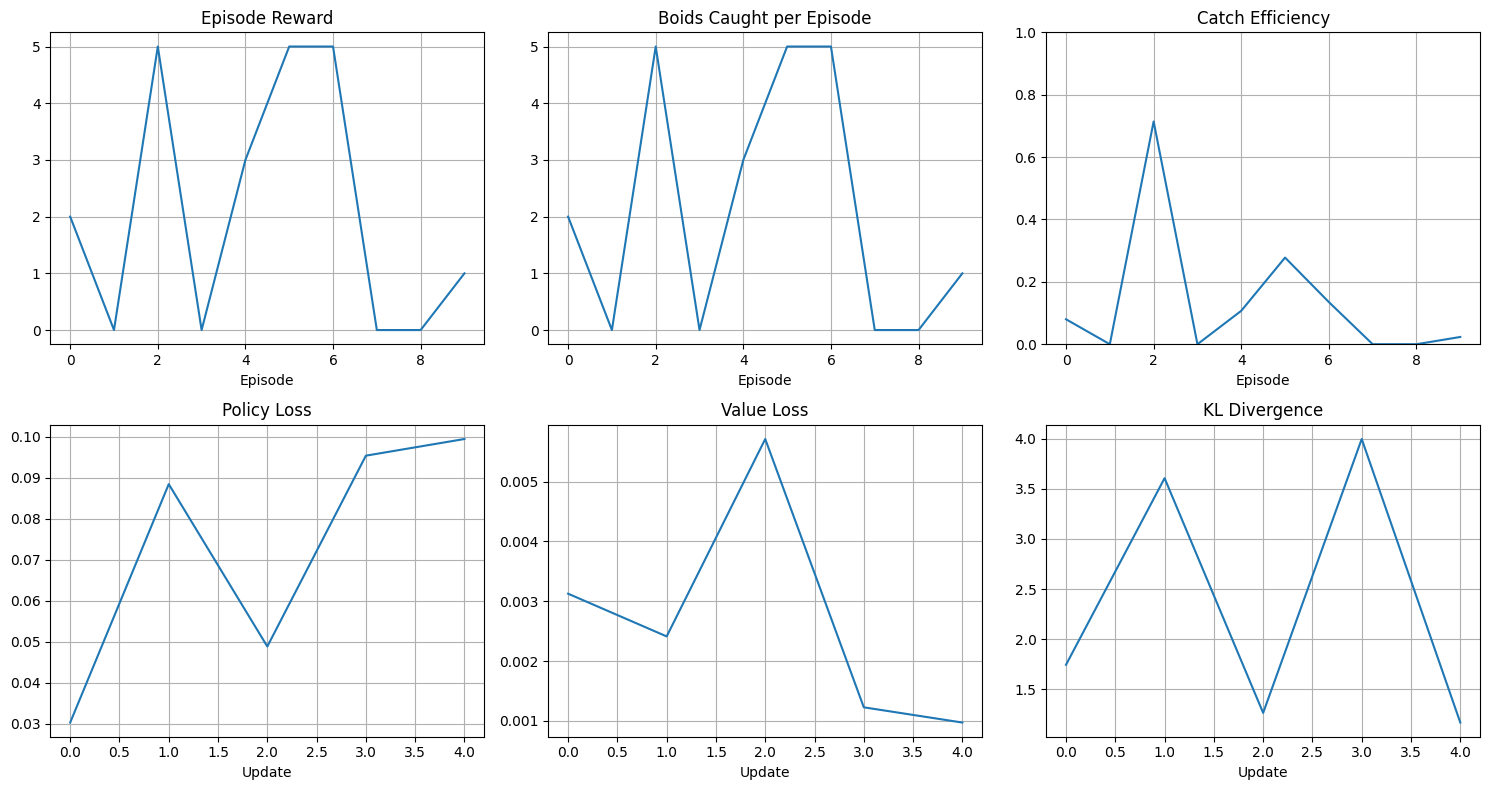

\n🎯 RL Training system is ready!
To run full training, call:
  final_monitor = train_ppo(trainer, monitor, num_updates=100, eval_interval=10, save_interval=25)
\nThe trained model can then be exported back to JavaScript using export_to_js.py


In [ ]:
# Main Training Loop with Metrics and Monitoring
class TrainingMonitor:
    """Monitor training progress with comprehensive metrics"""

    def __init__(self):
        self.performance_metrics = defaultdict(list)
        self.learning_metrics = defaultdict(list)
        self.behavioral_metrics = defaultdict(list)

        self.episode_count = 0
        self.step_count = 0

    def update_episode_metrics(self, episode_stats, episode_reward):
        """Update metrics after episode completion"""
        self.episode_count += 1

        # Performance metrics
        self.performance_metrics['boids_caught_per_episode'].append(episode_stats['boids_caught'])
        self.performance_metrics['catch_efficiency'].append(episode_stats['efficiency'])
        self.performance_metrics['episode_reward'].append(episode_reward)
        self.performance_metrics['episode_length'].append(episode_stats.get('step_count', 0))

        # Success rate (rolling average)
        success = 1.0 if episode_stats['efficiency'] >= 0.8 else 0.0
        self.performance_metrics['success_rate'].append(success)

        # Catch timing metrics
        if episode_stats['boids_caught'] > 0:
            self.performance_metrics['catches_per_episode'].append(episode_stats['boids_caught'])
            self.performance_metrics['steps_per_catch'].append(episode_stats['steps_per_catch'])

    def update_training_metrics(self, training_metrics):
        """Update learning metrics from PPO training"""
        for key, values in training_metrics.items():
            if values:  # Only add if there are values
                self.learning_metrics[key].append(values[-1])

    def get_recent_performance(self, window=100):
        """Get recent performance statistics"""
        if len(self.performance_metrics['episode_reward']) < window:
            window = len(self.performance_metrics['episode_reward'])

        if window == 0:
            return {}

        recent_rewards = self.performance_metrics['episode_reward'][-window:]
        recent_catches = self.performance_metrics['boids_caught_per_episode'][-window:]
        recent_efficiency = self.performance_metrics['catch_efficiency'][-window:]
        recent_success = self.performance_metrics['success_rate'][-window:]

        return {
            'avg_reward': np.mean(recent_rewards),
            'avg_catches': np.mean(recent_catches),
            'avg_efficiency': np.mean(recent_efficiency),
            'success_rate': np.mean(recent_success),
            'episodes': window
        }

    def plot_training_progress(self):
        """Plot training progress"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))

        # Performance metrics
        if self.performance_metrics['episode_reward']:
            axes[0, 0].plot(self.performance_metrics['episode_reward'])
            axes[0, 0].set_title('Episode Reward')
            axes[0, 0].set_xlabel('Episode')
            axes[0, 0].grid(True)

        if self.performance_metrics['boids_caught_per_episode']:
            axes[0, 1].plot(self.performance_metrics['boids_caught_per_episode'])
            axes[0, 1].set_title('Boids Caught per Episode')
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].grid(True)

        if self.performance_metrics['catch_efficiency']:
            axes[0, 2].plot(self.performance_metrics['catch_efficiency'])
            axes[0, 2].set_title('Catch Efficiency')
            axes[0, 2].set_xlabel('Episode')
            axes[0, 2].set_ylim([0, 1])
            axes[0, 2].grid(True)

        # Learning metrics
        if self.learning_metrics['policy_loss']:
            axes[1, 0].plot(self.learning_metrics['policy_loss'])
            axes[1, 0].set_title('Policy Loss')
            axes[1, 0].set_xlabel('Update')
            axes[1, 0].grid(True)

        if self.learning_metrics['value_loss']:
            axes[1, 1].plot(self.learning_metrics['value_loss'])
            axes[1, 1].set_title('Value Loss')
            axes[1, 1].set_xlabel('Update')
            axes[1, 1].grid(True)

        if self.learning_metrics['kl_divergence']:
            axes[1, 2].plot(self.learning_metrics['kl_divergence'])
            axes[1, 2].set_title('KL Divergence')
            axes[1, 2].set_xlabel('Update')
            axes[1, 2].grid(True)

        plt.tight_layout()
        plt.show()

def save_checkpoint(actor, critic, trainer, monitor, update, is_best=False):
    """Save training checkpoint"""
    os.makedirs("checkpoints_rl", exist_ok=True)

    checkpoint = {
        'update': update,
        'actor_state_dict': actor.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': trainer.actor_optimizer.state_dict(),
        'critic_optimizer_state_dict': trainer.critic_optimizer.state_dict(),
        'training_metrics': dict(trainer.training_metrics),
        'performance_metrics': dict(monitor.performance_metrics),
        'architecture': sl_architecture,
        'config': PPO_CONFIG,
        'timestamp': datetime.now().isoformat()
    }

    # Save regular checkpoint
    checkpoint_path = f"checkpoints_rl/rl_model_update_{update}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Saved checkpoint: {checkpoint_path}")

    # Save best model
    if is_best:
        best_path = "checkpoints_rl/best_rl_model.pt"
        torch.save(checkpoint, best_path)
        print(f"✓ Saved best model: {best_path}")

    return checkpoint_path

def train_ppo(trainer, monitor, num_updates=100, eval_interval=10, save_interval=25):
    """Main PPO training loop"""
    print(f"🚀 Starting PPO training for {num_updates} updates...")
    print(f"  Evaluation interval: {eval_interval}")
    print(f"  Save interval: {save_interval}")

    best_avg_reward = -np.inf
    start_time = time.time()

    for update in range(1, num_updates + 1):
        update_start_time = time.time()

        # Collect rollout and train
        metrics = trainer.train_step()

        # Update learning metrics
        monitor.update_training_metrics(metrics)

        # Evaluation episodes
        if update % eval_interval == 0:
            print(f"\\n--- Update {update}/{num_updates} Evaluation ---")

            eval_rewards = []
            eval_stats = []

            # Run evaluation episodes
            for eval_ep in range(5):  # 5 evaluation episodes
                obs = env.reset()
                episode_reward = 0
                done = False

                while not done:
                    action, _, _ = trainer.get_action_and_value(obs, deterministic=True)
                    obs, reward, done, info = env.step(action)
                    episode_reward += reward

                eval_rewards.append(episode_reward)
                eval_stats.append(env.get_episode_stats())

                # Update episode metrics
                monitor.update_episode_metrics(env.get_episode_stats(), episode_reward)

            # Evaluation summary
            avg_reward = np.mean(eval_rewards)
            avg_catches = np.mean([stats['boids_caught'] for stats in eval_stats])
            avg_efficiency = np.mean([stats['efficiency'] for stats in eval_stats])

            print(f"  Avg reward: {avg_reward:.3f}")
            print(f"  Avg catches: {avg_catches:.1f}")
            print(f"  Avg efficiency: {avg_efficiency:.3f}")

            # Recent performance
            recent_perf = monitor.get_recent_performance(window=50)
            if recent_perf:
                print(f"  Recent performance (50 episodes):")
                print(f"    Avg reward: {recent_perf['avg_reward']:.3f}")
                print(f"    Success rate: {recent_perf['success_rate']:.3f}")

            # Check if best model
            is_best = avg_reward > best_avg_reward
            if is_best:
                best_avg_reward = avg_reward
                print(f"  🎯 New best average reward: {best_avg_reward:.3f}")

            # Learning metrics
            if metrics['policy_loss']:
                print(f"  Policy loss: {metrics['policy_loss'][-1]:.4f}")
                print(f"  Value loss: {metrics['value_loss'][-1]:.4f}")
                print(f"  KL divergence: {metrics['kl_divergence'][-1]:.6f}")

        # Save checkpoint
        if update % save_interval == 0 or update == num_updates:
            save_checkpoint(actor, critic, trainer, monitor, update,
                          is_best=(update % eval_interval == 0 and avg_reward > best_avg_reward))

        # Progress update
        update_time = time.time() - update_start_time
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / update) * (num_updates - update)

        if update % eval_interval == 0:
            print(f"  Update time: {update_time:.1f}s, Elapsed: {elapsed_time/60:.1f}min, ETA: {remaining_time/60:.1f}min")

    print(f"\\n🎉 Training completed!")
    print(f"  Total time: {(time.time() - start_time)/60:.1f} minutes")
    print(f"  Best average reward: {best_avg_reward:.3f}")

    return monitor

# Initialize training monitor
monitor = TrainingMonitor()

# Run training (adjust num_updates as needed)
print("🏁 Starting RL training...")
print("Note: Adjust num_updates based on available time and compute")

# Small test run first
print("\\n🧪 Running a small test training (5 updates)...")
try:
    test_monitor = train_ppo(trainer, monitor, num_updates=5, eval_interval=2, save_interval=5)
    print("✅ Test training completed successfully!")

    # Plot initial results
    print("\\n📊 Plotting test training progress...")
    test_monitor.plot_training_progress()

except Exception as e:
    print(f"❌ Test training failed: {e}")
    raise

print(f"\\n🎯 RL Training system is ready!")
print(f"To run full training, call:")
print(f"  final_monitor = train_ppo(trainer, monitor, num_updates=100, eval_interval=10, save_interval=25)")
print(f"\\nThe trained model can then be exported back to JavaScript using export_to_js.py")
